In [1]:
import numpy as np
from basicpy import BaSiC
from scipy.ndimage import zoom
import zarr
from numcodecs import GZip 

from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
def transform(images, f, d=None):
    if d is not None:
        images_transformed = (np.clip(images-d[np.newaxis],0,None))/f[np.newaxis]
    else:
        images_transformed = images/f[np.newaxis]
        
    return images_transformed

In [3]:
path = "/u/home/f/f7xiesnm/project-zipursky/data/00_tiled/dapi_test.n5"
zarr_data = zarr.open(store=zarr.N5Store(path), mode='r')

In [4]:
print(zarr_data[f'/setup0/timepoint0/s0'].shape)
print(zarr_data[f'/setup0/timepoint0/s1'].shape)
print(zarr_data[f'/setup0/timepoint0/s2'].shape)
print(zarr_data[f'/setup0/timepoint0/s3'].shape)
print(zarr_data[f'/setup0/timepoint0/s4'].shape)

(2153, 1920, 1920)
(2153, 960, 960)
(1076, 480, 480)
(538, 240, 240)
(269, 120, 120)


In [5]:
images_raw = zarr_data[f'/setup0/timepoint0/s4'][...]
images_raw.shape

(269, 120, 120)

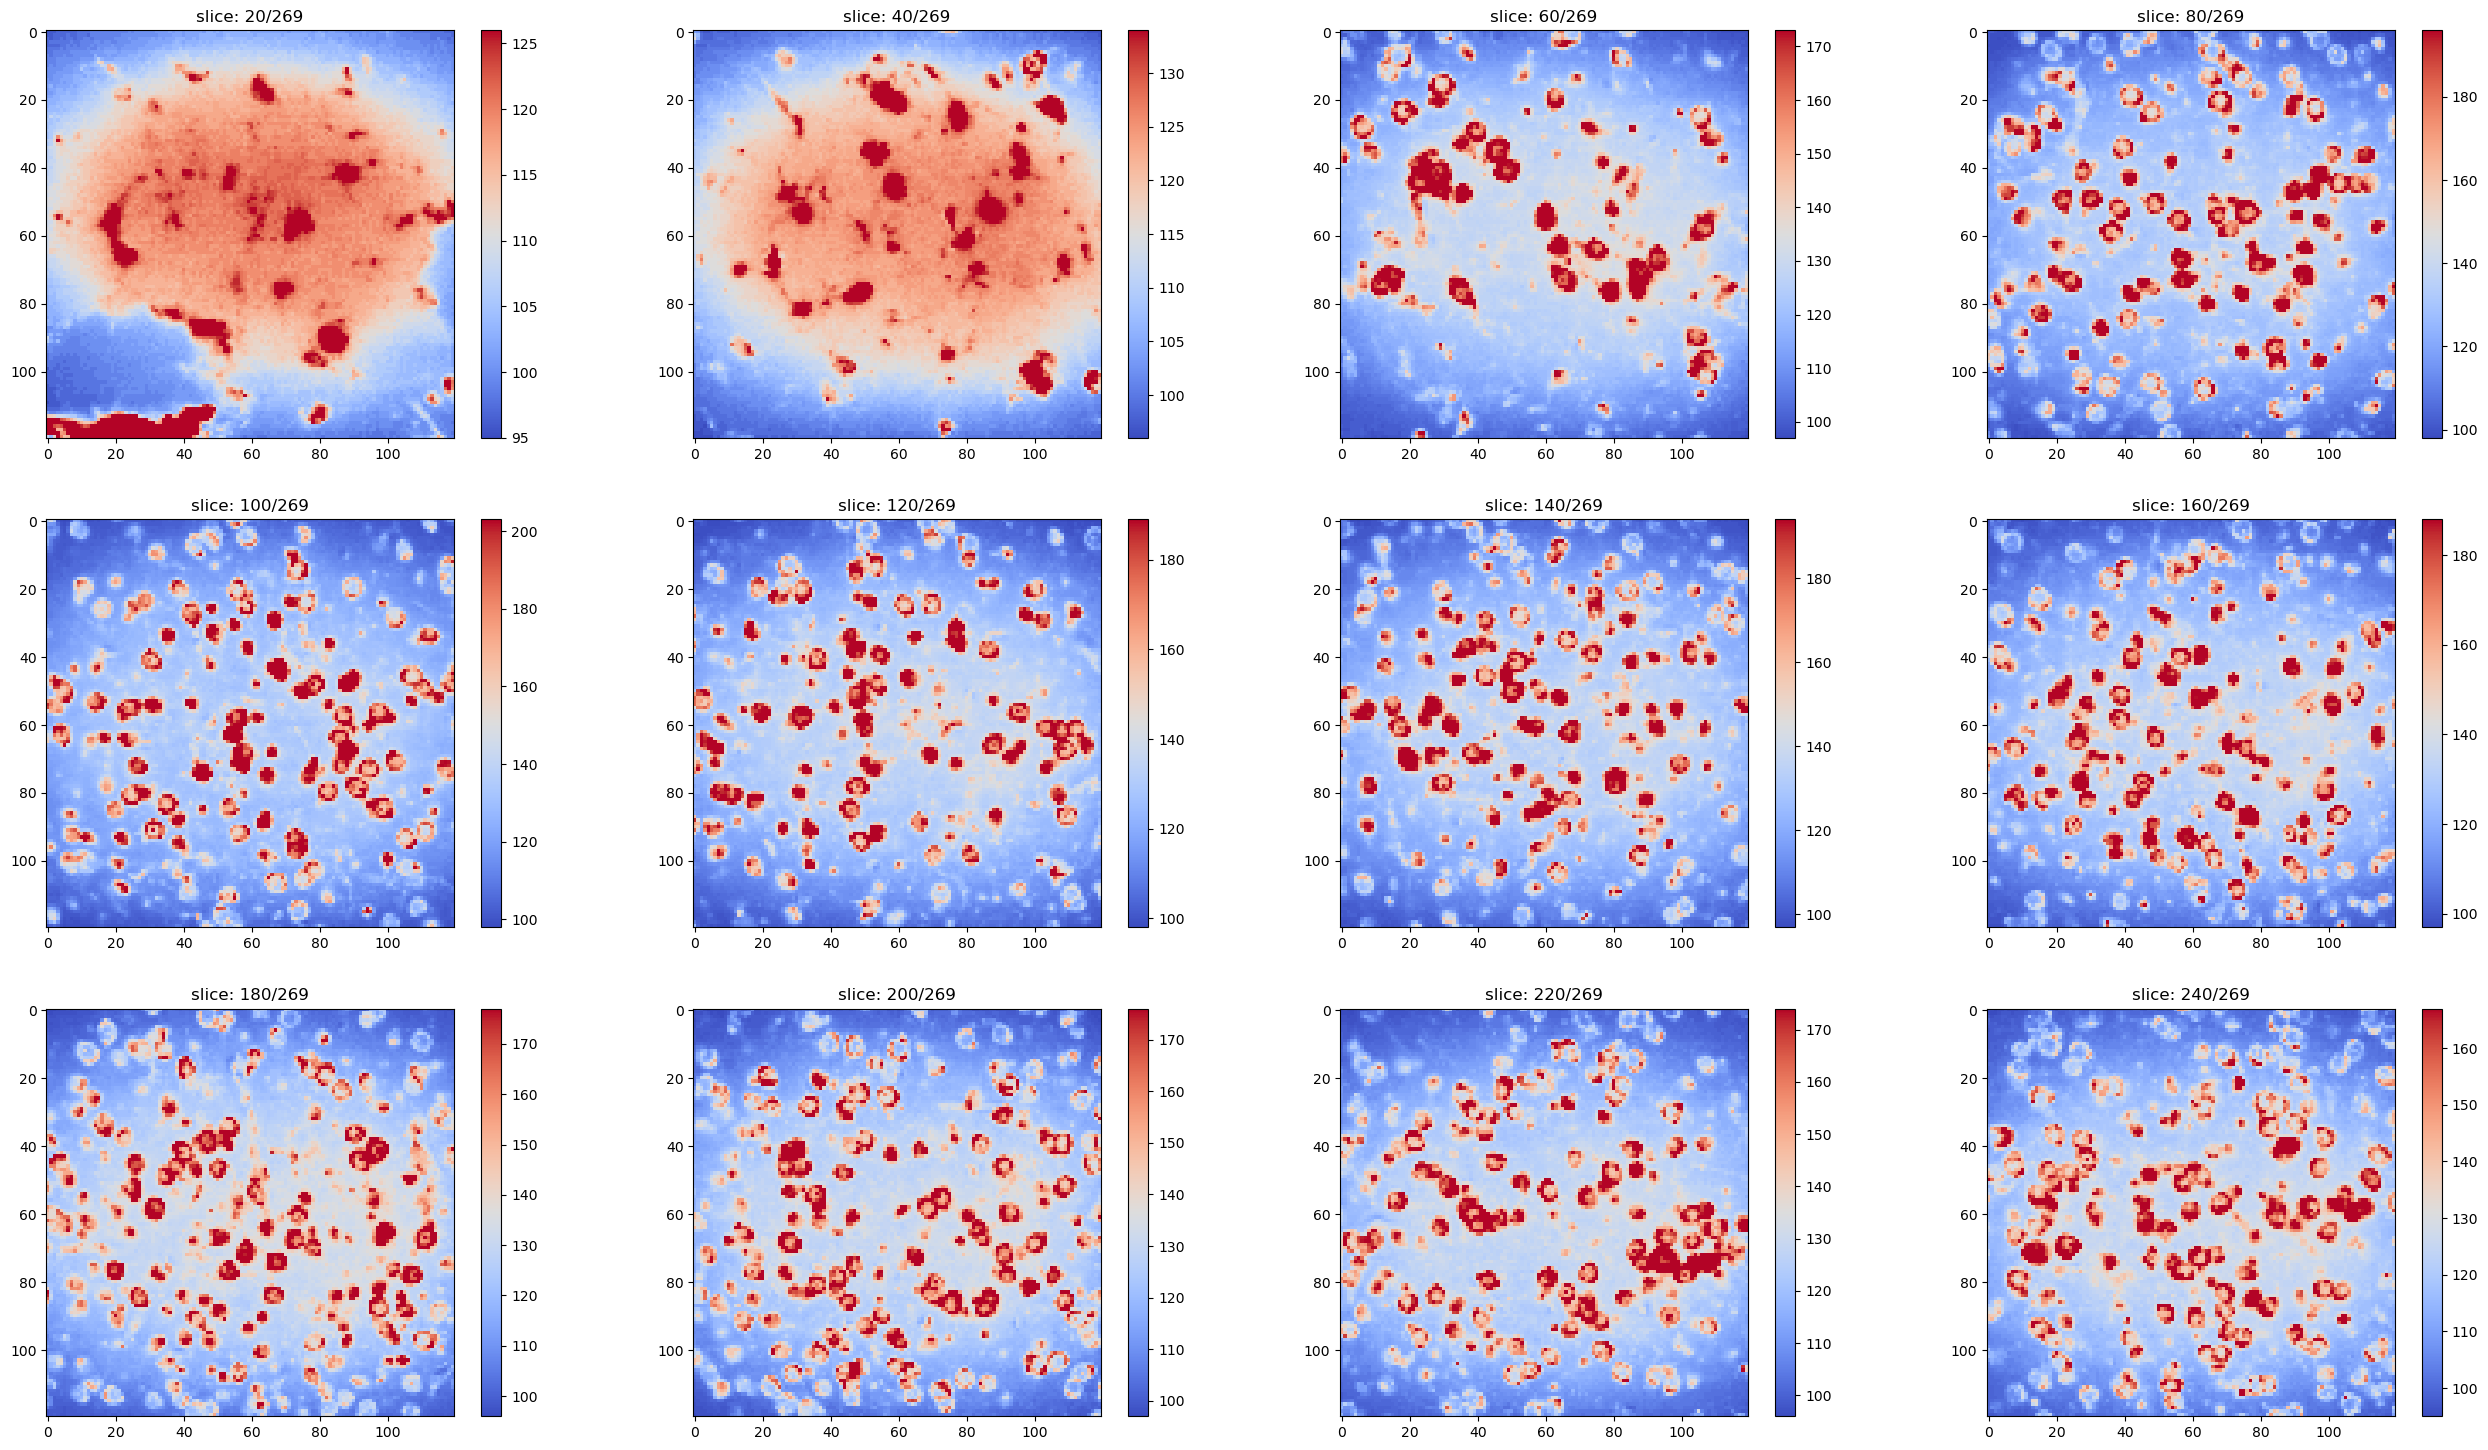

In [6]:
slices = [
     20, 40, 60, 80,
    100,120,140,160,
    180,200,220,240,
]

images_slcs = []
for slc in slices:
    img = images_raw[slc]
    images_slcs.append(img)
    
fig, axs = plt.subplots(3,4, figsize=(4*8,3*6))
for ax, slc, img in zip(axs.flat, slices, images_slcs): 
    
    vmax = np.percentile(img, 95)
    vmin = np.percentile(img,  5)
    g = ax.imshow(img, cmap='coolwarm', vmax=vmax)
    ax.set_title(f'slice: {slc}/{len(images_raw)}')
    fig.colorbar(g)

plt.show()

In [7]:
pctls = [0, 0.0001, 0.001, 1, 
         5, 10, 20, 40,  
         80, 90, 95, 99]
vects = []
for pctl in pctls:
    vec = np.percentile(images_raw, pctl, axis=0)
    vects.append(vec)

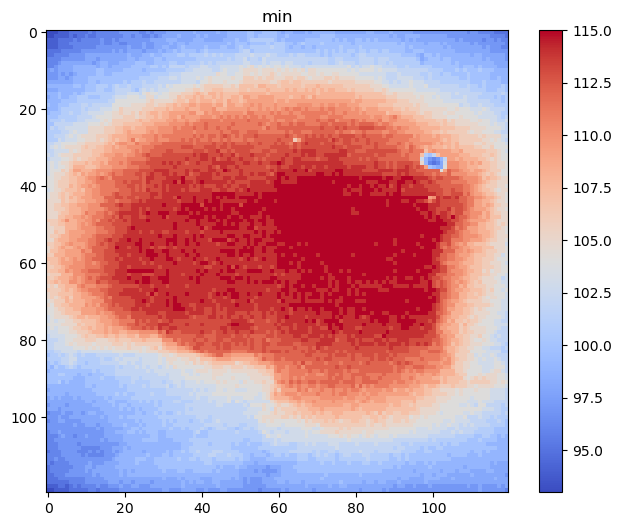

In [8]:
vec = np.min(images_raw, axis=0)
fig, ax = plt.subplots(figsize=(8,6))
vmax = np.percentile(vec, 95)
vmin = np.percentile(vec,  5)
g = ax.imshow(vec, cmap='coolwarm', vmax=vmax)
ax.set_title(f'min')
fig.colorbar(g)

plt.show()

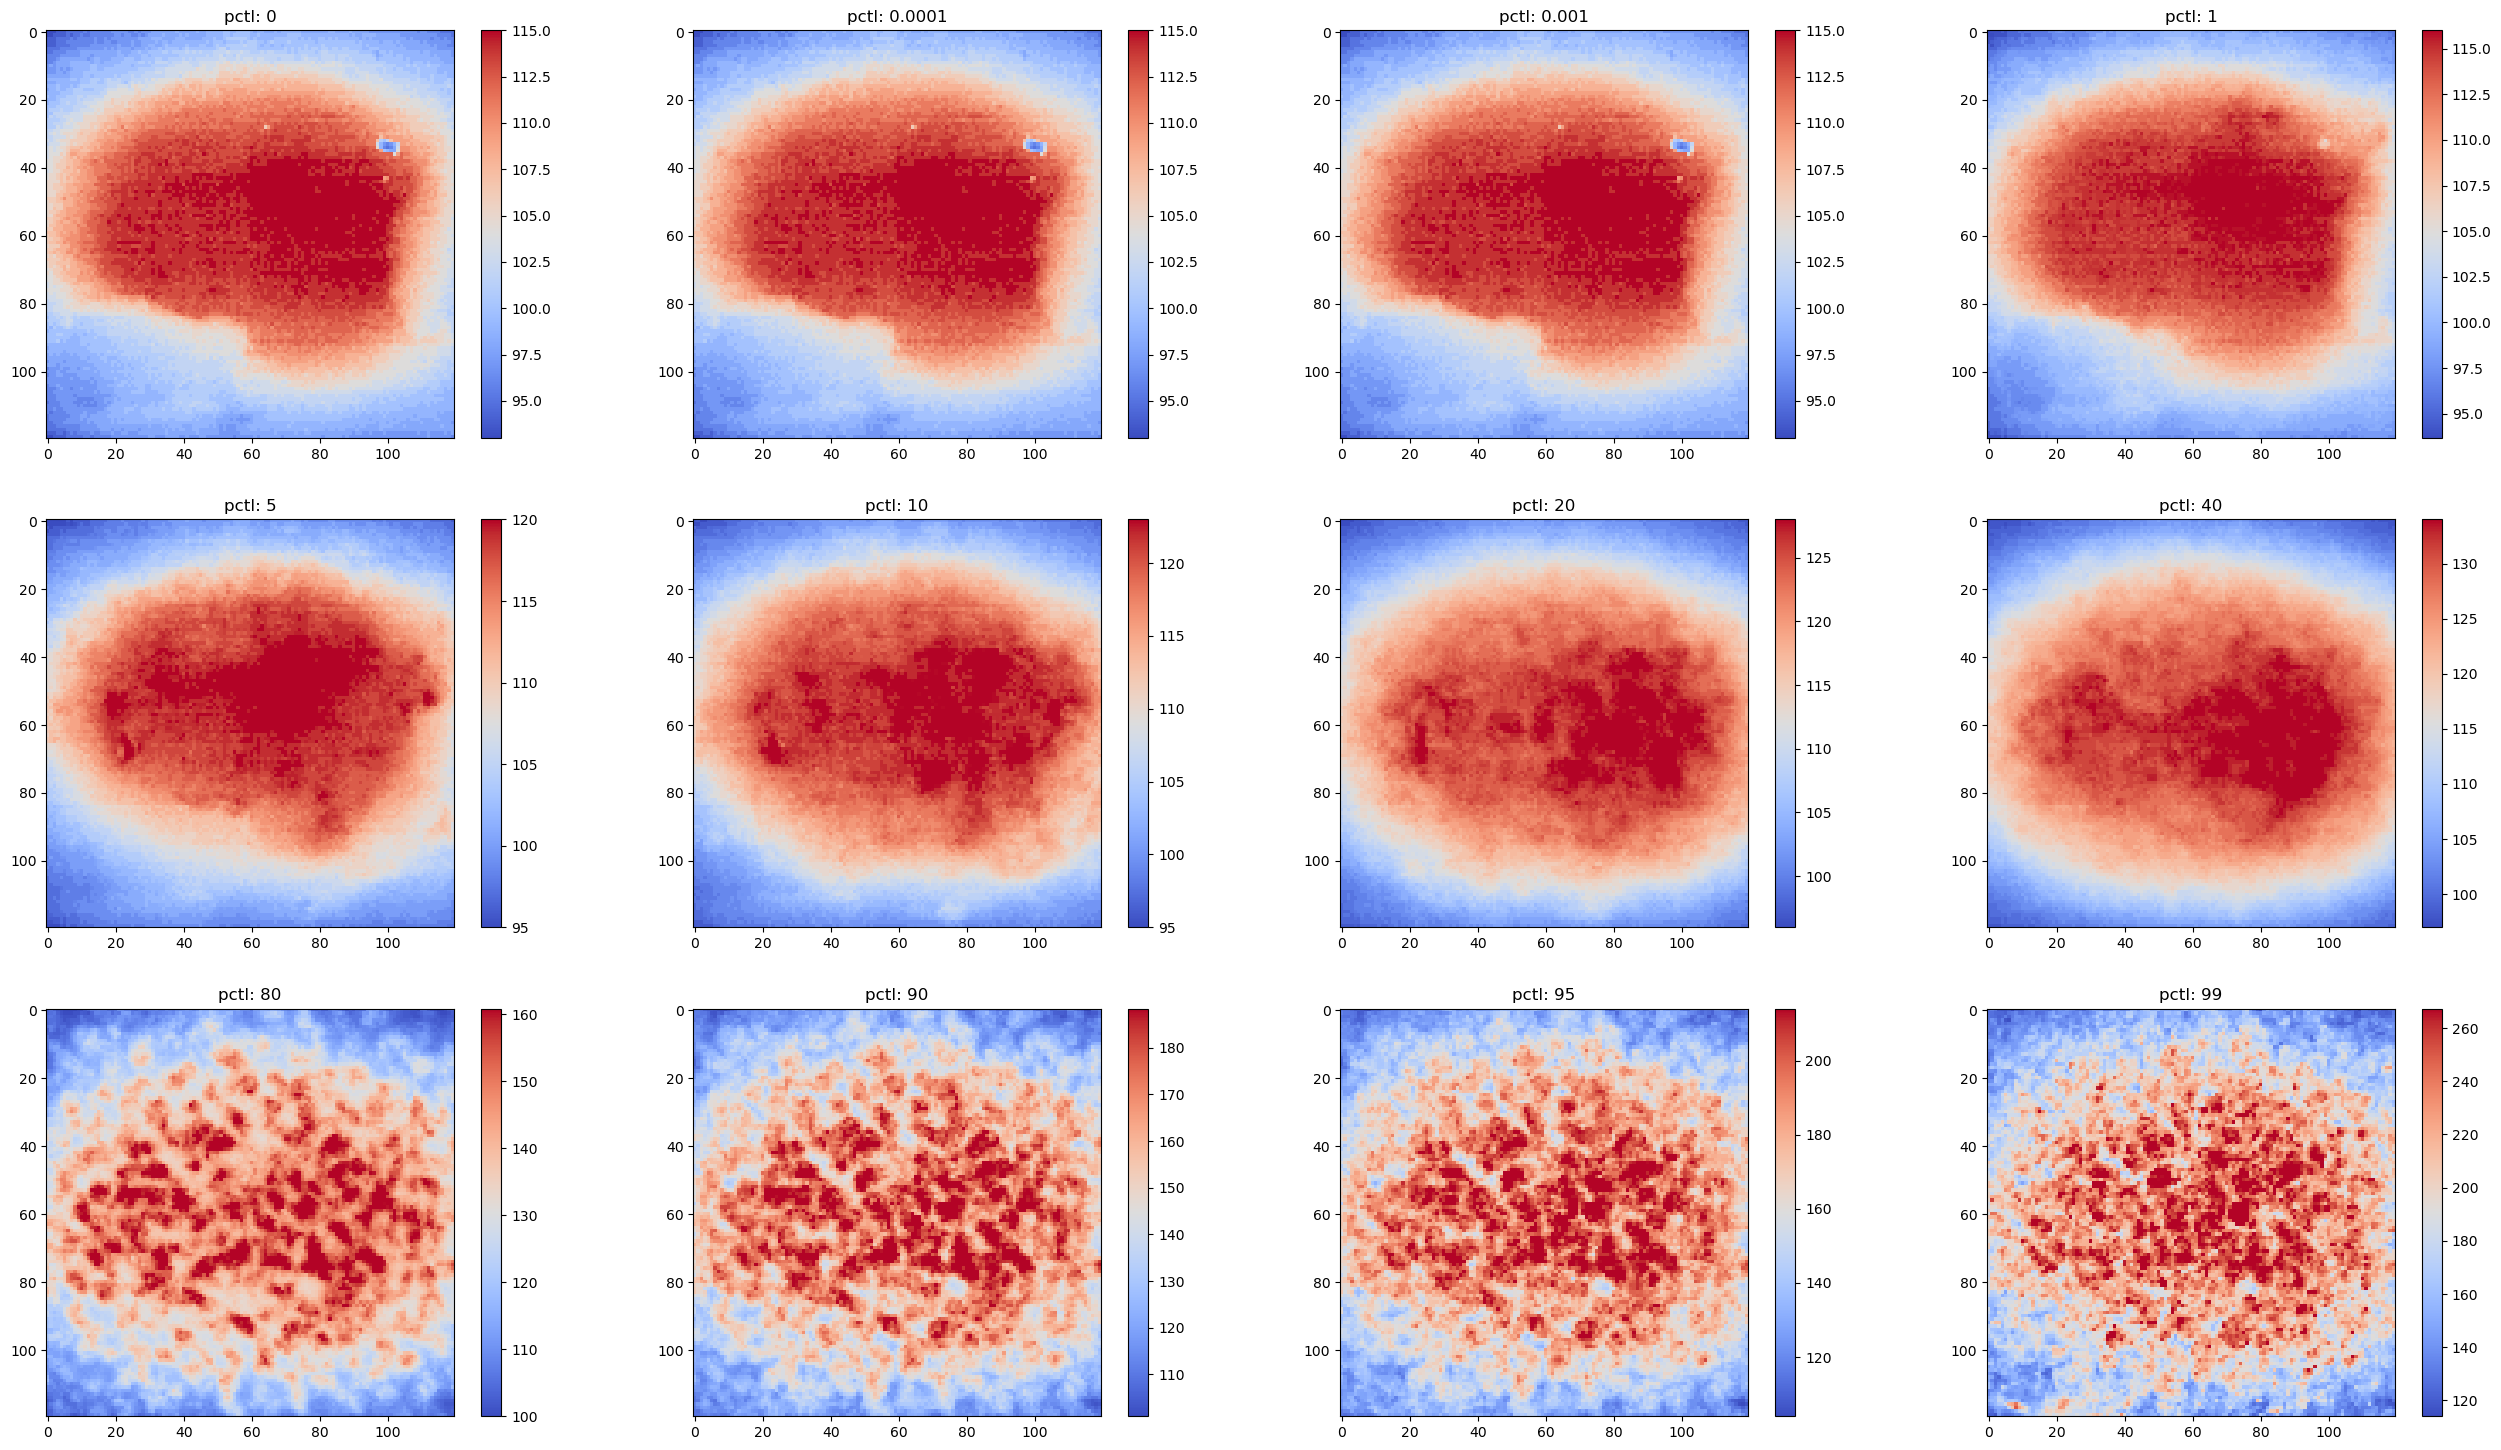

In [9]:
fig, axs = plt.subplots(3,4, figsize=(4*8,3*6))
for ax, pctl, vec in zip(axs.flat, pctls, vects): 
    vmax = np.percentile(vec, 95)
    vmin = np.percentile(vec,  5)
    g = ax.imshow(vec, cmap='coolwarm', vmax=vmax)
    ax.set_title(f'pctl: {pctl}')
    fig.colorbar(g)

plt.show()

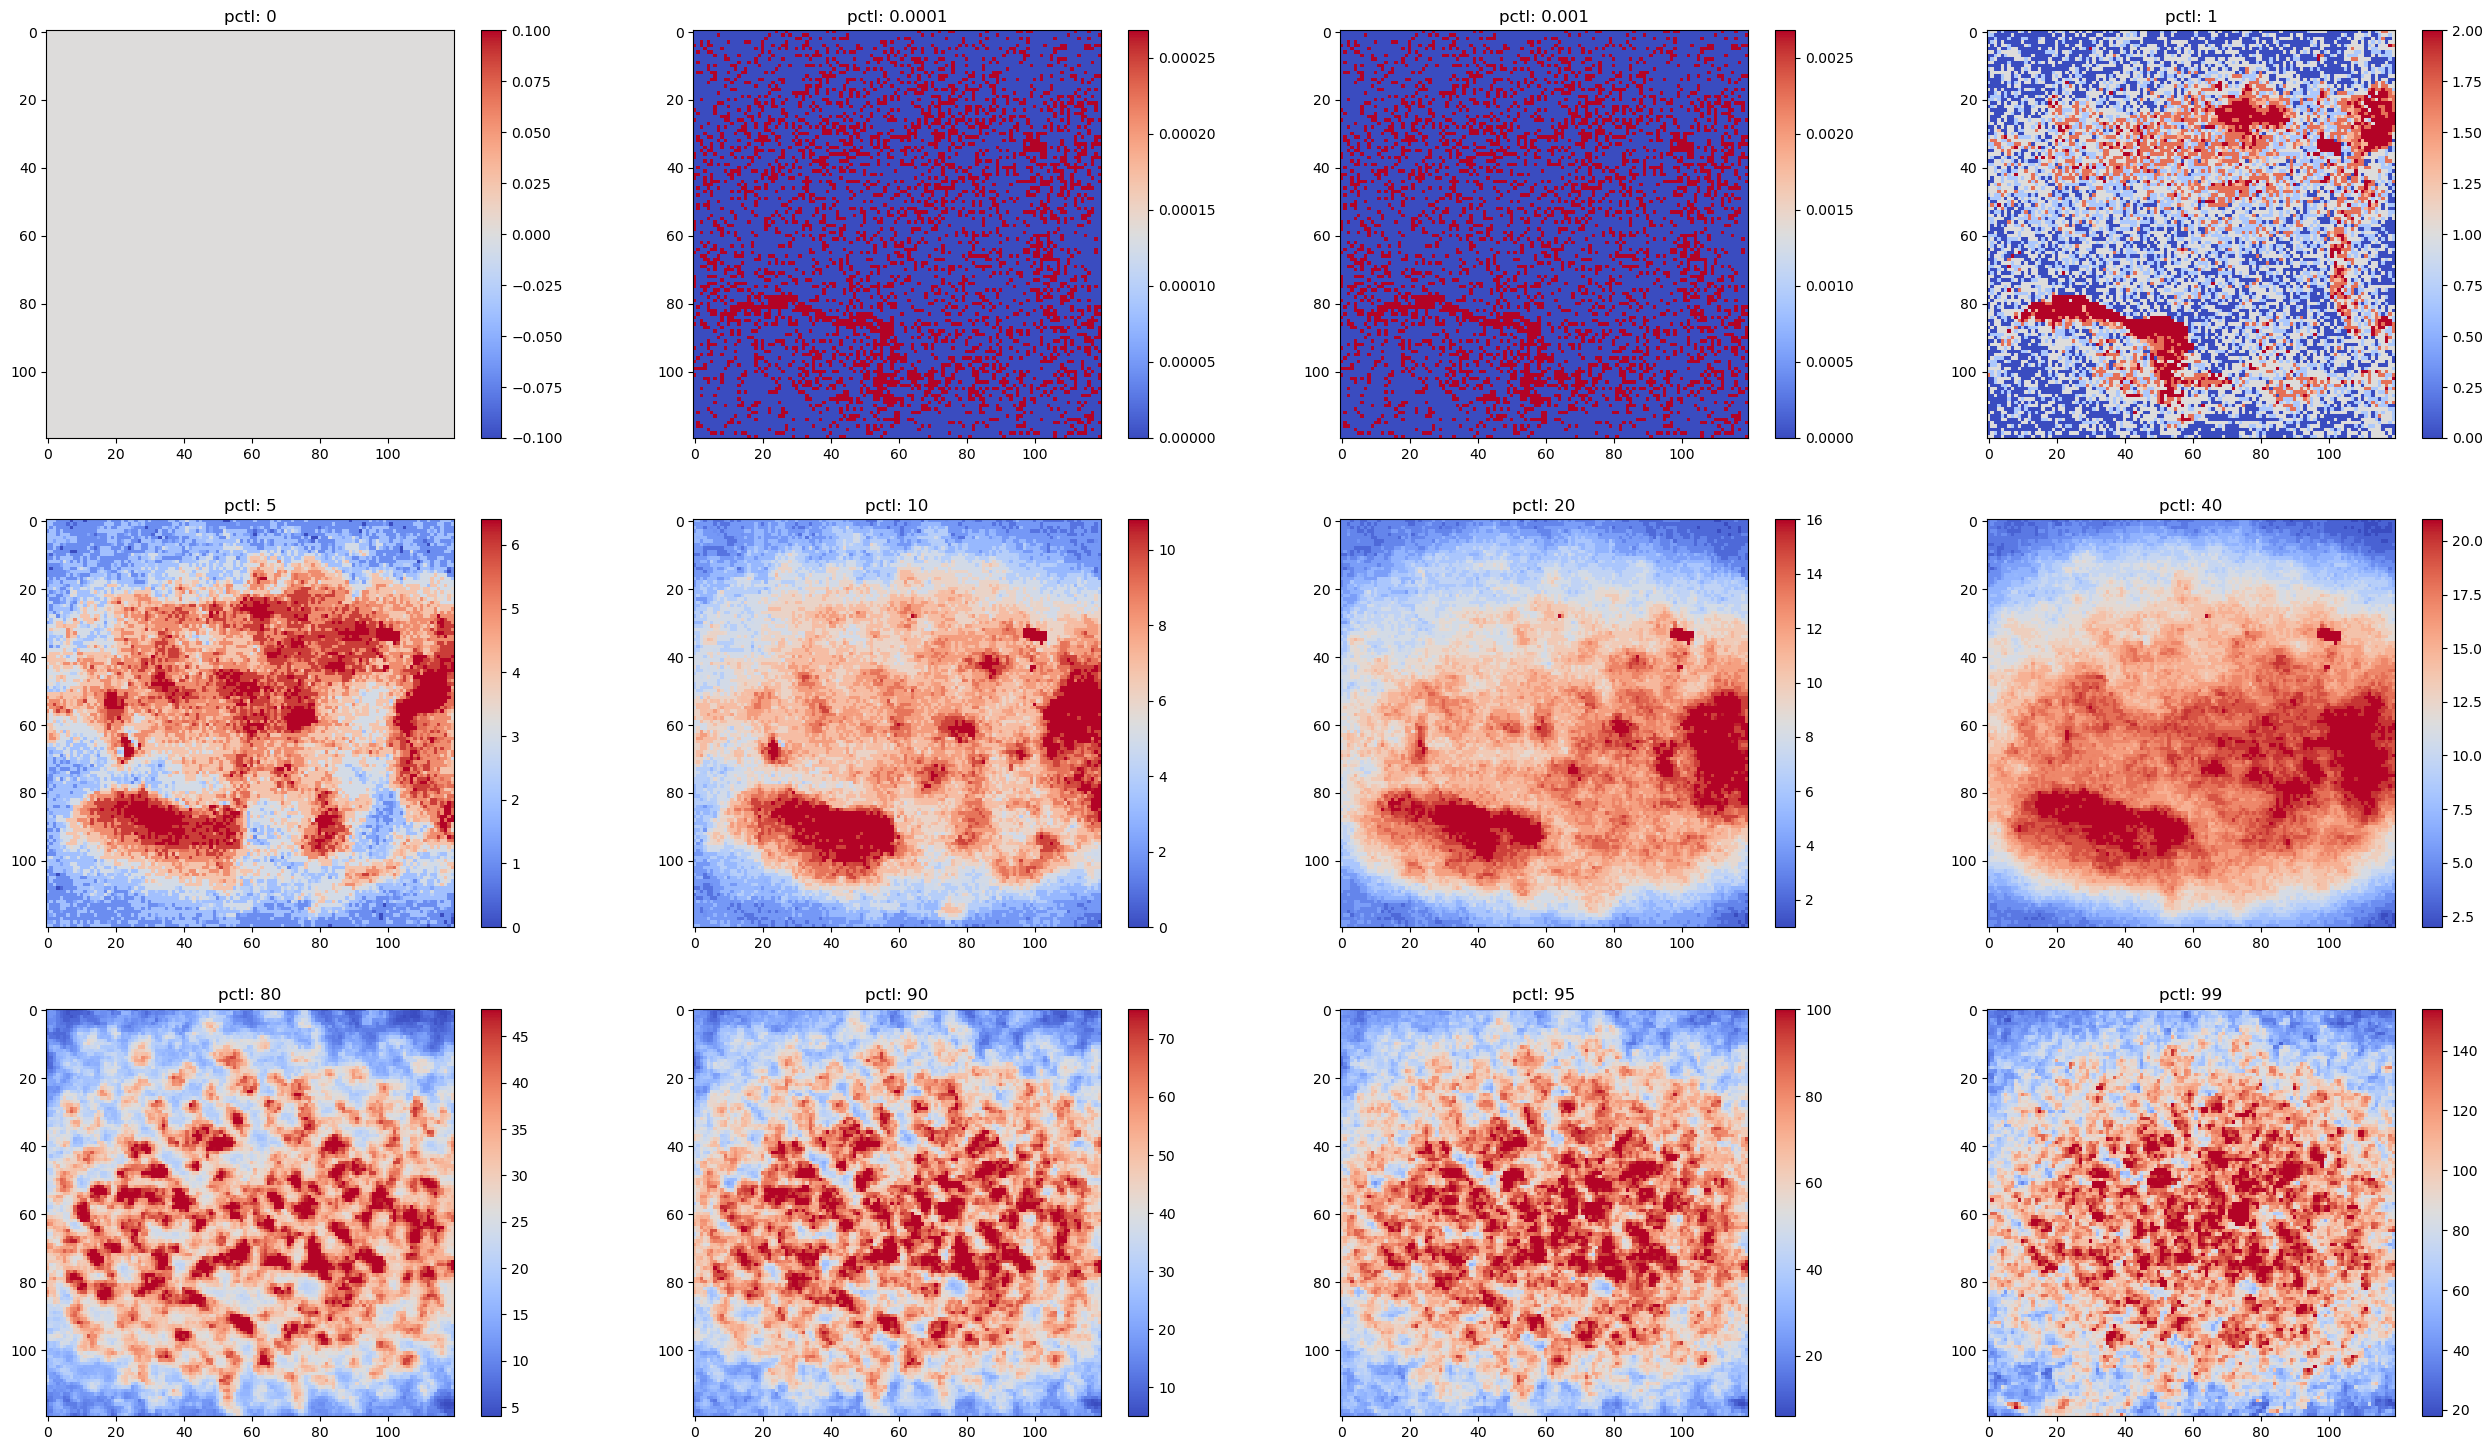

In [10]:
# fig, axs = plt.subplots(5,3, figsize=(3*8,5*6))
# for ax, pctl, vec in zip(axs.flat, pctls, vects): 
#     vec = vec - vects[0]
#     vmax = np.percentile(vec, 95)
#     vmin = np.percentile(vec,  5)
#     g = ax.imshow(vec, cmap='coolwarm', vmax=vmax)
#     ax.set_title(f'pctl: {pctl}')
#     fig.colorbar(g)
# plt.show()

fig, axs = plt.subplots(3,4, figsize=(4*8,3*6))
for ax, pctl, vec in zip(axs.flat, pctls, vects): 
    vec = vec - vects[0]
    vmax = np.percentile(vec, 95)
    vmin = np.percentile(vec,  5)
    g = ax.imshow(vec, cmap='coolwarm', vmax=vmax)
    ax.set_title(f'pctl: {pctl}')
    fig.colorbar(g)

plt.show()

# correct it

In [11]:
# images = zarr_data[f'/setup13/timepoint0/s4'][...]
images = images_raw.copy()
# dx = np.percentile(images,1, axis=0)
dx = 90*np.ones(images.shape[1:])
images = np.clip(images.astype(np.float16) - dx, 0, 1000).astype(np.uint16)

In [12]:
from skimage import restoration

ff0 = np.percentile(images, 50, axis=0)
bg = restoration.rolling_ball(ff0, radius=10)
ff = bg / np.mean(bg)

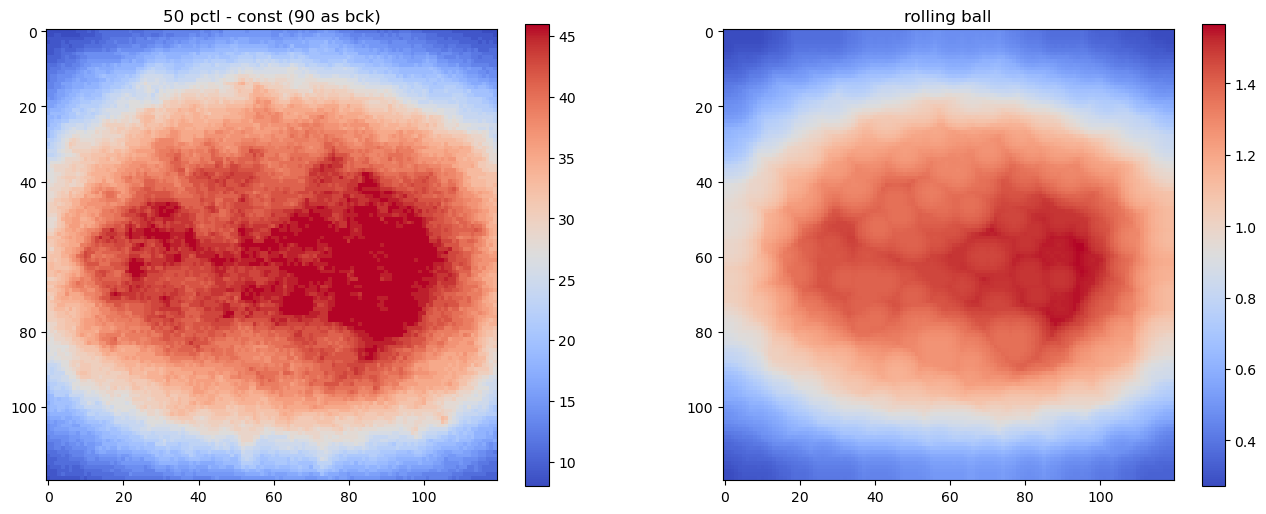

In [13]:
fig, axs = plt.subplots(1,2,figsize=(8*2, 6))

ax = axs[0]
vmax = np.percentile(ff0, 95)
g = ax.imshow(ff0, vmax=vmax, cmap='coolwarm') #, vmin=0, vmax=2)
ax.set_title('50 pctl - const (90 as bck)')
plt.colorbar(g)

ax = axs[1]
g = ax.imshow(ff, cmap='coolwarm',) # vmid=1) # vmin=0, vmax=2)
ax.set_title('rolling ball')
fig.colorbar(g)

plt.show()

In [14]:
import tifffile
outdir = '/u/home/f/f7xiesnm/project-zipursky/easifish/results/flatfield'
!mkdir -p $outdir

tifffile.imwrite(outdir+'/flatfield_dapi_test_rollingball_s4.tiff', ff)

In [15]:
images.shape

(269, 120, 120)

100
8.723237991333008


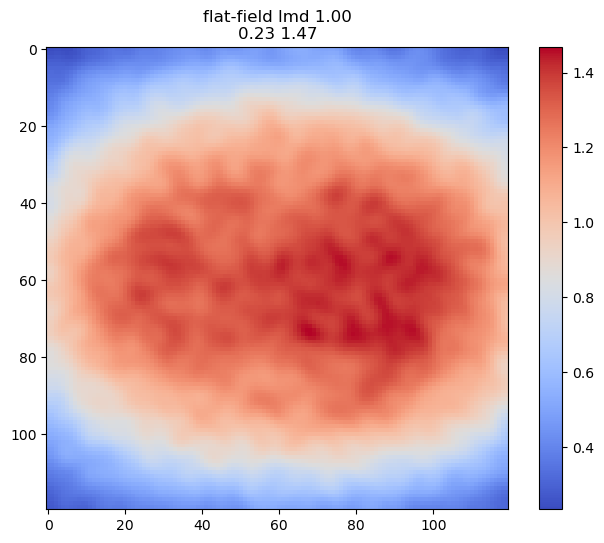

100
8.93697476387024


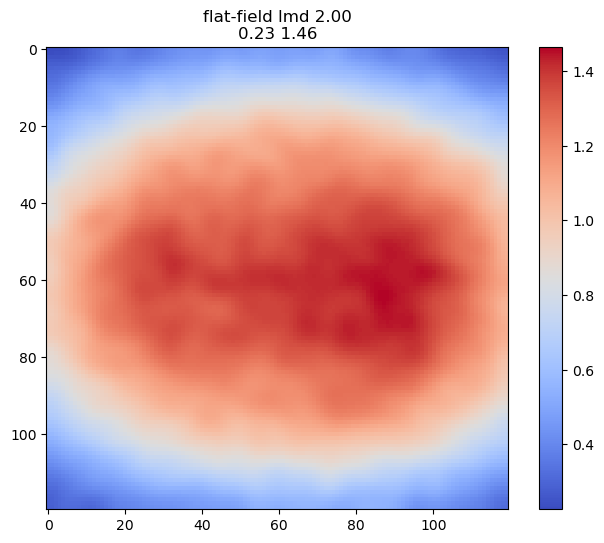

100
9.10552978515625


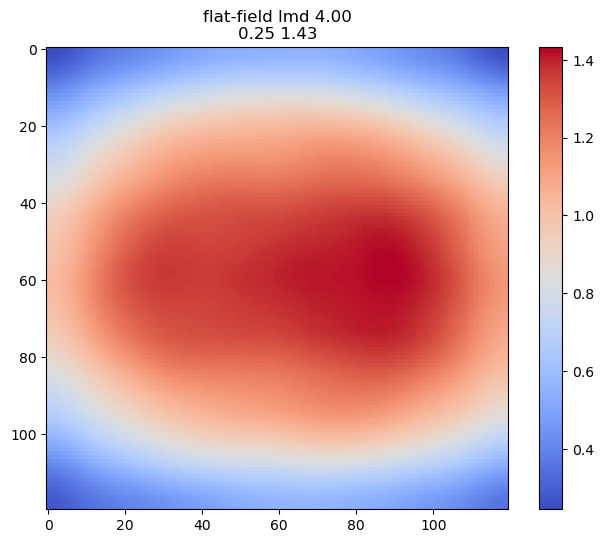

100


Single-step optimization did not converge at the last reweighting step.


25.464443922042847


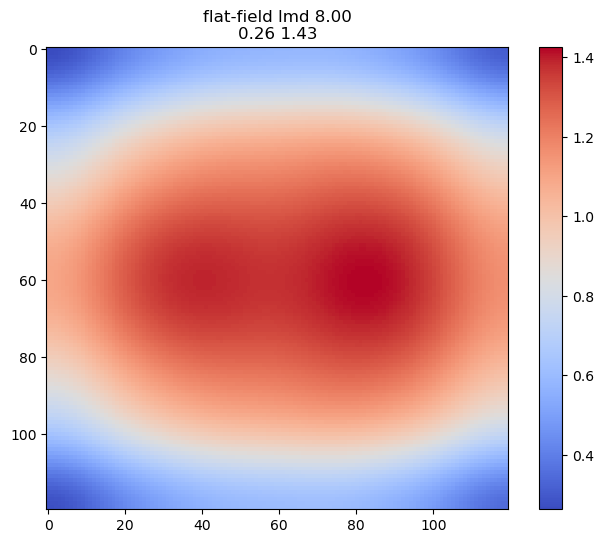

100


Single-step optimization did not converge at the last reweighting step.


24.42237901687622


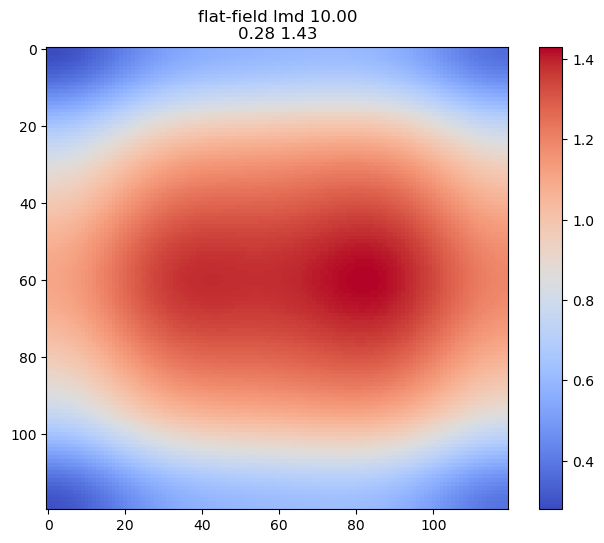

CPU times: user 2min 8s, sys: 2.43 s, total: 2min 11s
Wall time: 1min 18s


In [19]:
%%time
import time

np.random.seed(0)

n = 100
lmds = [1,2,4,8,10]

for lmd in lmds: 
    ti = time.time()
    print(n)
    
    idx = np.random.choice(len(images), n, replace=False)
    basic = BaSiC(get_darkfield=False, smoothness_flatfield=lmd, working_size=None, sort_intensity=True)
    basic.fit(images[idx])
    
    ff = basic.flatfield
    
    print(time.time()-ti)
    
    fig, ax = plt.subplots(1,1,figsize=(8*1, 6))
    g = ax.imshow(ff, cmap='coolwarm',) # vmid=1) # vmin=0, vmax=2)
    
    ffmin = np.min(ff)
    ffmax = np.max(ff)
    ax.set_title(f'flat-field lmd {lmd:.2f}\n{ffmin:.2f} {ffmax:.2f}')
    fig.colorbar(g)
    plt.show()
    

100
8.98996615409851


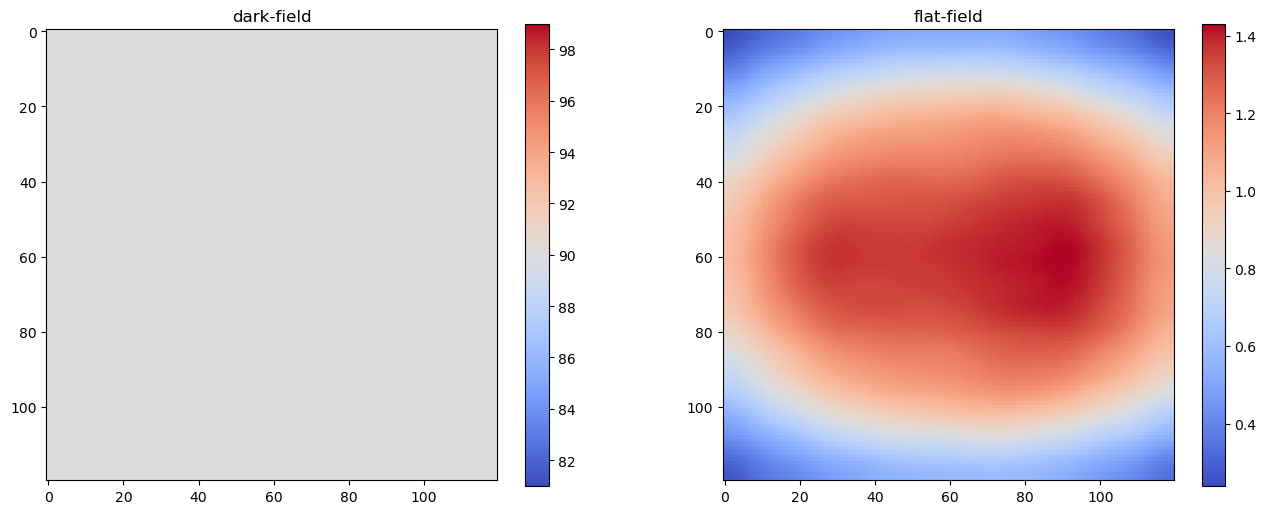

269


Single-step optimization did not converge at the last reweighting step.


73.0207359790802


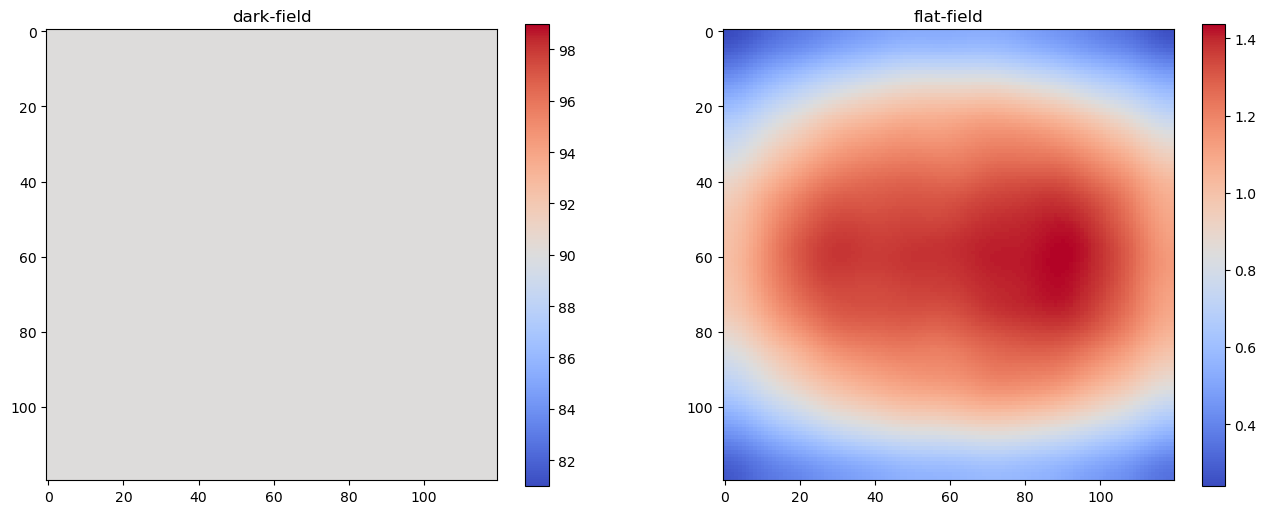

CPU times: user 2min 23s, sys: 1.92 s, total: 2min 25s
Wall time: 1min 23s


In [21]:
%%time
import time

np.random.seed(0)
lmd = 4

# for n in [100, 200, 400, 800, 1600, len(images)]:
for n in [100, len(images)]:
    ti = time.time()
    print(n)
    
    idx = np.random.choice(len(images), n, replace=False)
    basic = BaSiC(get_darkfield=False, smoothness_flatfield=lmd, working_size=None, sort_intensity=True)
    basic.fit(images[idx])
    
    ff = basic.flatfield
    
    print(time.time()-ti)
    
    fig, axs = plt.subplots(1,2,figsize=(8*2, 6))
    ax = axs[0]
    g = ax.imshow(dx, cmap='coolwarm') #, vmin=0, vmax=2)
    ax.set_title('dark-field')
    plt.colorbar(g)
    ax = axs[1]
    g = ax.imshow(ff, cmap='coolwarm',) # vmid=1) # vmin=0, vmax=2)
    ax.set_title('flat-field')
    fig.colorbar(g)
    plt.show()
    

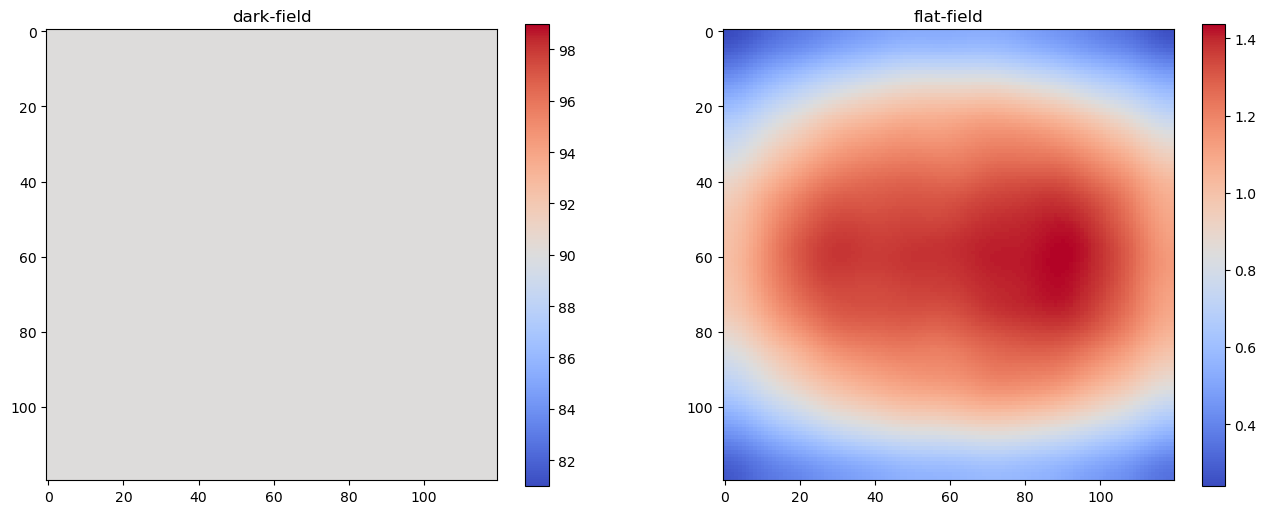

In [22]:

fig, axs = plt.subplots(1,2,figsize=(8*2, 6))
ax = axs[0]
g = ax.imshow(dx, cmap='coolwarm') #, vmin=0, vmax=2)
ax.set_title('dark-field')
plt.colorbar(g)
ax = axs[1]
g = ax.imshow(ff, cmap='coolwarm',) # vmid=1) # vmin=0, vmax=2)
ax.set_title('flat-field')
fig.colorbar(g)
plt.show()


In [23]:
import tifffile
outdir = '/u/home/f/f7xiesnm/project-zipursky/easifish/results/flatfield'
!mkdir -p $outdir

tifffile.imwrite(outdir+'/flatfield_dapi_test_basicpy_s4.tiff', ff)